In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("perrin-freres-monthly-champagne-.csv")
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


### Initial investigation

In [3]:
data.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72':'Sales'},inplace=True)

In [4]:
data.dtypes

Month     object
Sales    float64
dtype: object

In [5]:
data.isnull().sum()

Month    1
Sales    2
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data['Month']=pd.to_datetime(data['Month'])

In [8]:
data.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

### Data visulaization

<AxesSubplot:>

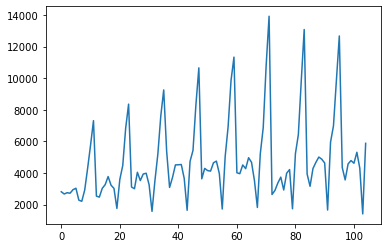

In [9]:
data['Sales'].plot()
# data is non-stationary and seasonal

In [10]:
# Testing seasionality by using Dicky fuller test
from statsmodels.tsa.stattools import adfuller

In [11]:
test_result=adfuller(data['Sales'])

In [12]:
test_result

(-1.8335930563276184,
 0.36391577166024713,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [13]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ") 

In [14]:
adfuller_test(data['Sales'])

ADF Test Statistic : -1.8335930563276184
p-value : 0.36391577166024713
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Differencing

In [15]:
data['Sales First Difference'] = data['Sales'] - data['Sales'].shift(1)

In [16]:
data.head()

,Month,Sales,Sales First Difference
0,1964-01-01,2815.0,NaN
1,1964-02-01,2672.0,-143.0
2,1964-03-01,2755.0,83.0
3,1964-04-01,2721.0,-34.0
4,1964-05-01,2946.0,225.0


In [17]:
data['Seasonal First Difference']=data['Sales']-data['Sales'].shift(12)
# since the data is seasional (one cycle-12 months), hence shift i

In [18]:
data

,Month,Sales,Sales First Difference,Seasonal First Difference
0,1964-01-01,2815.0,NaN,NaN
1,1964-02-01,2672.0,-143.0,NaN
2,1964-03-01,2755.0,83.0,NaN
3,1964-04-01,2721.0,-34.0,NaN
4,1964-05-01,2946.0,225.0,NaN
...,...,...,...,...
100,1972-05-01,4618.0,-170.0,-392.0
101,1972-06-01,5312.0,694.0,438.0
102,1972-07-01,4298.0,-1014.0,-335.0
103,1972-08-01,1413.0,-2885.0,-246.0


In [19]:
#data.dropna(inplace=True)

In [20]:
adfuller_test(data['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:>

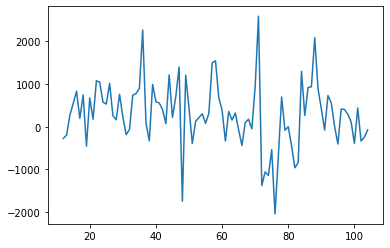

In [21]:
data['Seasonal First Difference'].plot()

### ACF and PCF plot

In [22]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

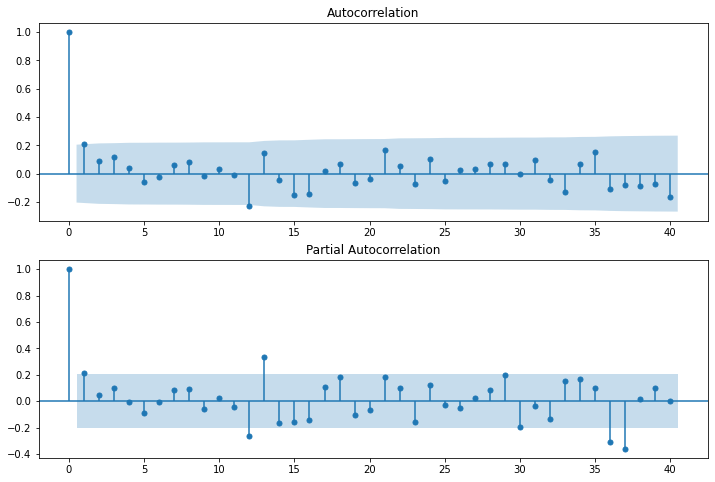

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [24]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [25]:
model=ARIMA(data['Sales'],order=(1,1,1))
model_fit=model.fit()

In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Fri, 26 Nov 2021   AIC                           1910.251
Time:                        16:34:20   BIC                           1920.829
Sample:                             1   HQIC                          1914.536
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7843     12.405      1.837      0.066      -1.529      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

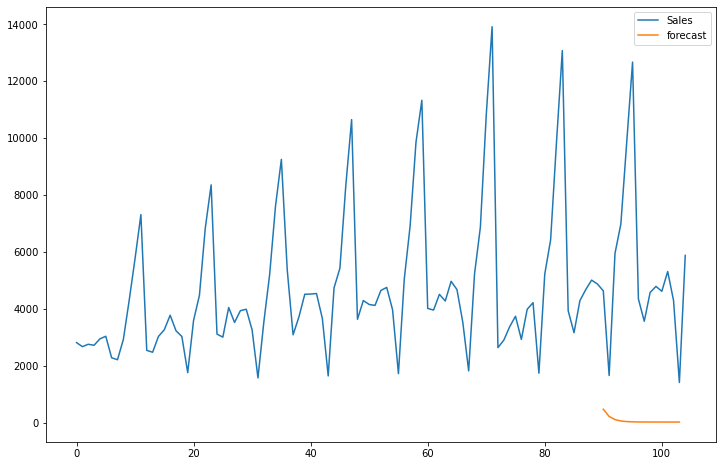

In [27]:
data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

In [28]:
data['forecast']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
100    22.891937
101    22.831068
102    22.804630
103    22.793147
104          NaN
Name: forecast, Length: 105, dtype: float64

Used for non-seasional data, but here data are seasional hence accuracy is low for ARIMA model

For seasional model, SARIMA model is used

### SARIMA model

In [29]:
import statsmodels.api as sm

In [30]:
model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [34]:
data.drop('forecast',axis=1,inplace=True)

<AxesSubplot:>

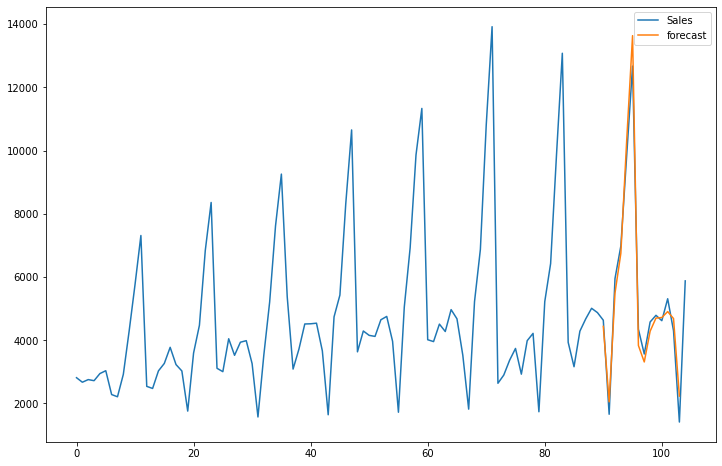

In [36]:
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

In [37]:
data.columns

Index(['Month', 'Sales', 'Sales First Difference', 'Seasonal First Difference',
       'forecast'],
      dtype='object')

In [38]:
data.drop('forecast',axis=1,inplace=True)

In [39]:
data

,Month,Sales,Sales First Difference,Seasonal First Difference
0,1964-01-01,2815.0,NaN,NaN
1,1964-02-01,2672.0,-143.0,NaN
2,1964-03-01,2755.0,83.0,NaN
3,1964-04-01,2721.0,-34.0,NaN
4,1964-05-01,2946.0,225.0,NaN
...,...,...,...,...
100,1972-05-01,4618.0,-170.0,-392.0
101,1972-06-01,5312.0,694.0,438.0
102,1972-07-01,4298.0,-1014.0,-335.0
103,1972-08-01,1413.0,-2885.0,-246.0


In [40]:
data.set_index('Month',inplace=True)

In [41]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)] #predicting for next 24 months

In [42]:
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [43]:
future_date_set=pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_date_set

,Sales,Sales First Difference,Seasonal First Difference
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN


In [44]:
data

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
...,...,...,...
1972-05-01,4618.0,-170.0,-392.0
1972-06-01,5312.0,694.0,438.0
1972-07-01,4298.0,-1014.0,-335.0


In [45]:
future_data=pd.concat([data,future_date_set])
future_data

,Sales,Sales First Difference,Seasonal First Difference
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
...,...,...,...
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN


In [48]:
future_data['forecast']

1964-01-01   NaN
1964-02-01   NaN
1964-03-01   NaN
1964-04-01   NaN
1964-05-01   NaN
              ..
1974-04-01   NaN
1974-05-01   NaN
1974-06-01   NaN
1974-07-01   NaN
1974-08-01   NaN
Name: forecast, Length: 128, dtype: float64

In [50]:
future_data.iloc[104:]

,Sales,Sales First Difference,Seasonal First Difference,forecast
1972-09-01,5877.0,4464.0,-74.0,NaN
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN,NaN


In [52]:
future_data.reset_index(inplace=True)

In [53]:
future_data

,index,Sales,Sales First Difference,Seasonal First Difference,forecast
0,1964-01-01,2815.0,NaN,NaN,NaN
1,1964-02-01,2672.0,-143.0,NaN,NaN
2,1964-03-01,2755.0,83.0,NaN,NaN
3,1964-04-01,2721.0,-34.0,NaN,NaN
4,1964-05-01,2946.0,225.0,NaN,NaN
...,...,...,...,...,...
123,1974-04-01,NaN,NaN,NaN,NaN
124,1974-05-01,NaN,NaN,NaN,NaN
125,1974-06-01,NaN,NaN,NaN,NaN
126,1974-07-01,NaN,NaN,NaN,NaN


<AxesSubplot:>

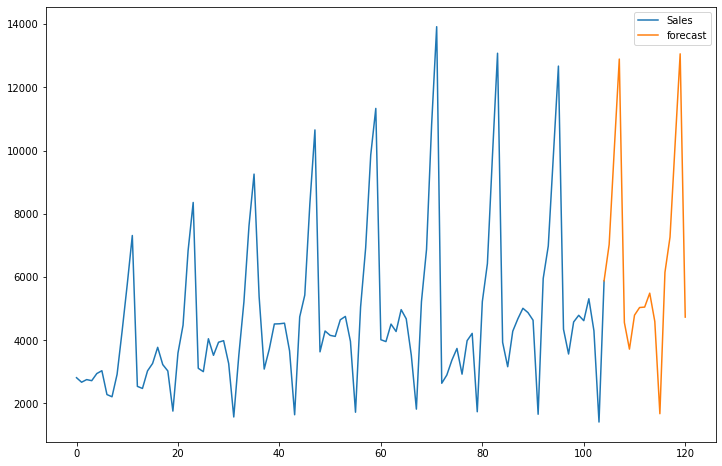

In [54]:
future_data['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_data[['Sales', 'forecast']].plot(figsize=(12, 8)) 